# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('./arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/timloehr/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [7]:
print(azdias.shape)
azdias.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
print(customers.shape)
customers.head()

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
attribute_info = pd.read_excel('./arvato_data/DIAS_information.xlsx').drop('Unnamed: 0', axis=1)

In [11]:
more_info = pd.read_excel('./arvato_data/DIAS_attributes.xlsx')

In [12]:
topics = attribute_info[~attribute_info['Unnamed: 1'].isna()]['Unnamed: 1'].values
print(topics)

['Information level' 'Person' 'Household' 'Building' 'Microcell (RR4_ID)'
 'Microcell (RR3_ID)' '125m x 125m Grid' 'Postcode ' 'RR1_ID' 'PLZ8'
 'Community']


In [13]:
topic_dict = {topic : [] for topic in topics}

for i, (topic, sub) in enumerate(zip(attribute_info['Unnamed: 1'], attribute_info['Unnamed: 2'])):
    if(topic is not np.nan):
        cur_topic = topic
        topic_dict[cur_topic].append(sub)
    
    if(topic is np.nan):
        topic_dict[cur_topic].append(sub)
        
topic_dict['Information level'] = topic_dict['Information level'].pop(1)

In [14]:
topic_dict['Information level']

'AGER_TYP'

In [15]:
print(sum(map(len, topic_dict.values())))
print(len(more_info['Unnamed: 1'].unique()))

320
316


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### General Population Analysis

In [16]:
a_feats = pd.DataFrame(columns=['unique_vals', 'perc_is_na'])

for col in azdias.columns:
    vals = int(len(azdias[col].unique()))
    perc = round((np.sum(azdias[col].isna()) / azdias.shape[0])*100, 2)
    a_feats.loc[col] = [vals, perc]
    
a_feats = a_feats.sort_values(['perc_is_na', 'unique_vals'], ascending=False)

In [17]:
a_feats.head(5)

,unique_vals,perc_is_na
ALTER_KIND4,13.0,99.86
ALTER_KIND3,16.0,99.31
ALTER_KIND2,18.0,96.69
ALTER_KIND1,18.0,90.90
EXTSEL992,57.0,73.40


In [18]:
a_feats.tail(5)

,unique_vals,perc_is_na
HEALTH_TYP,4.0,0.0
NATIONALITAET_KZ,4.0,0.0
VERS_TYP,3.0,0.0
GREEN_AVANTGARDE,2.0,0.0
ANREDE_KZ,2.0,0.0


### Customers Analysis

In [19]:
c_feats = pd.DataFrame(columns=['unique_vals', 'perc_is_na'])

for col in customers.columns:
    vals = int(len(customers[col].unique()))
    perc = round((np.sum(customers[col].isna()) / customers.shape[0])*100, 2)
    c_feats.loc[col] = [vals, perc]
    
c_feats = c_feats.sort_values(['perc_is_na', 'unique_vals'], ascending=False)

In [20]:
c_feats.head(5)

,unique_vals,perc_is_na
ALTER_KIND4,11.0,99.88
ALTER_KIND3,15.0,99.33
ALTER_KIND2,18.0,97.34
ALTER_KIND1,18.0,93.86
KK_KUNDENTYP,7.0,58.41


In [21]:
c_feats.tail(5)

,unique_vals,perc_is_na
PRODUCT_GROUP,3.0,0.0
GREEN_AVANTGARDE,2.0,0.0
CUSTOMER_GROUP,2.0,0.0
ONLINE_PURCHASE,2.0,0.0
ANREDE_KZ,2.0,0.0


In [22]:
unique_cols = list(set(customers.columns.values) - set(azdias.columns.values))

print("Rows in costumer set that are not in azdias: " + str(unique_cols) + "\n")

for unique_col in unique_cols:
    print("Unique values for column: " + str(unique_col) + " - " + str(set(customers[unique_col].values)))
    
print()
    
for unique_col in unique_cols:
    counts = customers[unique_col].value_counts()
    sum_c = np.sum(customers[unique_col].value_counts())
    print(str(unique_col))
    
    for idx in counts.index:
        print(str(idx) + ": " + str(round(counts[idx] / sum_c ,3) * 100) + "%")
        
    print(25*"=")

Rows in costumer set that are not in azdias: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

Unique values for column: CUSTOMER_GROUP - {'MULTI_BUYER', 'SINGLE_BUYER'}
Unique values for column: ONLINE_PURCHASE - {0, 1}
Unique values for column: PRODUCT_GROUP - {'FOOD', 'COSMETIC_AND_FOOD', 'COSMETIC'}

CUSTOMER_GROUP
MULTI_BUYER: 69.0%
SINGLE_BUYER: 31.0%
ONLINE_PURCHASE
0: 91.0%
1: 9.0%
PRODUCT_GROUP
COSMETIC_AND_FOOD: 52.6%
FOOD: 24.7%
COSMETIC: 22.7%


### Compare General public population to Customers

In [23]:
len(customers.columns)

369

In [24]:
cleaned_customers = customers.copy()
cleaned_customers = cleaned_customers[customers['GEBURTSJAHR'] != 0]

cleaned_azdias = azdias.copy()
cleaned_azdias = cleaned_azdias[azdias['GEBURTSJAHR'] != 0]

In [25]:
print(cleaned_customers.shape)
print(cleaned_azdias.shape)

(98628, 369)
(498903, 366)


In [26]:
compare_az_cus = pd.DataFrame(columns=['a_max', 'c_max', 'a_min', 'c_min', 'a_mean', 'c_mean', 'a_median', 'c_median', 'mean_diff'])

common_cols = np.intersect1d(azdias.columns, customers.columns)

for col in common_cols:
    if(customers[col].dtype == int):
        
        a_max = cleaned_azdias[col].max()
        c_max = cleaned_customers[col].max()
        a_min = cleaned_azdias[col].min()
        c_min = cleaned_customers[col].min()
        a_mean = cleaned_azdias[col].mean()
        c_mean = cleaned_customers[col].mean()
        a_median = cleaned_azdias[col].median()
        c_median = cleaned_customers[col].median()
        diff = np.abs(a_mean - c_mean)
        
        compare_az_cus.loc[col] = a_max, c_max,  a_min, c_min, a_mean, c_mean, a_median, c_median, diff
        
    else:  
        try:
            a_max = cleaned_azdias[col].max()
            c_max = cleaned_customers[col].max()
            a_min = cleaned_azdias[col].min()
            c_min = cleaned_customers[col].min()

            compare_az_cus.loc[col] = a_max, c_max,  a_min, c_min, np.nan, np.nan, np.nan, np.nan, np.nan
        except:
            
            compare_az_cus.loc[col] = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan


In [27]:
compare = compare_az_cus[~compare_az_cus['c_mean'].isna()].loc[compare_az_cus['mean_diff'] > 0.5].sort_values('mean_diff', ascending=False).drop('LNR', axis=0)

In [28]:
compare.head(25)

,a_max,c_max,a_min,c_min,a_mean,c_mean,a_median,c_median,mean_diff
GEBURTSJAHR,2017.0,2017.0,1900.0,1900.0,1967.102689,1949.773127,1968.0,1948.0,17.329562
PRAEGENDE_JUGENDJAHRE,15.0,15.0,0.0,0.0,9.797127,5.984528,10.0,5.0,3.812599
D19_KONSUMTYP_MAX,9.0,9.0,1.0,1.0,4.699110,2.596098,4.0,2.0,2.103011
D19_SONSTIGE,7.0,7.0,0.0,0.0,2.984290,4.349607,3.0,6.0,1.365317
D19_BUCH_CD,7.0,7.0,0.0,0.0,2.180179,3.445604,0.0,5.0,1.265424
FINANZ_SPARER,5.0,5.0,1.0,1.0,2.751312,1.492335,3.0,1.0,1.258978
D19_SAMMELARTIKEL,7.0,7.0,0.0,0.0,0.781246,1.984558,0.0,0.0,1.203312
FINANZ_ANLEGER,5.0,5.0,1.0,1.0,2.892917,1.701312,3.0,1.0,1.191605
SEMIO_LUST,7.0,7.0,1.0,1.0,4.187199,5.372998,4.0,6.0,1.185799
FINANZ_VORSORGER,5.0,5.0,1.0,1.0,3.350758,4.494839,4.0,5.0,1.144082


# Analysis

### Person Topic
- The average age of Arvato customers is 70 years old. Whereas the overall average age of the population dataset is around 50 years old people. They are most likeli cutural driven eldery.
- The customers are more likeli to have their teens in the "60ies - economic miracle (Mainstream, O+W)", whereas the median of the entire german population had their teens in the "80ies - Generation Golf (Mainstream, W)" of this dataset.
- The average Arvato customers has a saving behaviour of saving "very high", whereas the wide population is only a "average" savor. This could lead to the conclusion Arvato is targeting people which potentially have more money on the bank.
- Additionally, customers have a median value of financial investors to be very high with an overall median of average behavior. So Arvato customers are more likeli to invest money.
- Another small deviation is the finiancial minimalism. Arvato customers appear to be less financially minimalistic than the regular population.
- Customers have according to the dataset a lower affinity for a sensual mindset.
- Customers furthermore have a slightly affinity for being traditionally minded.

### Household Topic
- The customers have a median consumption type value of "Versatile" instead of the wider population which has a consumption type of "Family". This leads to the conclusion that Arvato is not really after families, but wants to send ads to people with a versatile lifestyle.

### 125m x 125m Grid Topic
- The average customer is a Buyer > 24 months, which means that the transactional activity based on the product group ALL OTHER CATEGORIES is way higher than the average population which is averaglely a Singlebuyer 0-12 months.

- Furthermore, the customers of Arvato have a median value of buying books in the last 13-24 months, whereas the overall population didn't buy so many books. This could be an indicator for a more academic target.

- A very interesting point is that the target for customers is people with transactional activity based on the product group COMPLETE MAIL-ORDER OFFERS is Multi-/Doublebuyer 13-24 months, whereas the entire population's behavior is unknown or very low. The target is people who bought things since a 2 years period of time.

### Specific Customer Behaviour
- Product Group: This is very equally distributed between food and cosmetic. There is no clear tendency that either women or men are more likely to be customers. 

- Online Purchase: This is undeniably the case the most customers (91%) are buying the things online. So a digital marketing campaign for online purchasers makes a lot of sense.

- Customer Group: This is most often multi buyers (69%) and only (31%) are single buyers. Since there is no further information about this column, I assume it means that people who buy at Arvato are (69%) people who already bought something in the past from Arvato. This was already shown above in "125m x 125m Grid Topic", that Arvato customers frequently multi buy things online.


#### I used the cell below to investigate the meaning behind the values

In [29]:
# To print the information for the values in this sub-topic's

#more_info[2055:2066:5] # PRAEGENDE_JUGENDJAHRE
#more_info[385:389] # D19_KONSUMTYP
#more_info[463:471:3] # D19_SONSTIGE_RZ
#more_info[258:264:5] # D19_BUCH_RZ
#more_info[632:640] # D19_VOLLSORTIMENT_RZ
#more_info[662:686] # Financial fields
#more_info[2155:2170] # SEMIO_PFLICHT
#more_info[2187:2195] # SEMIO_TRADV

## Heatmap for the Customer correlation

In [30]:
additional_cols = np.array(['FINANZ_UNAUFFAELLIGER', 'D19_GESAMT_ONLINE_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'SEMIO_TRADV', 'ALTERSKATEGORIE_GROB'])

In [31]:
columns = np.concatenate((np.array(compare.index[:15]), additional_cols, np.array(unique_cols)), axis=0)

heatmap_c = customers[columns]
heatmap_c = heatmap_c[heatmap_c['GEBURTSJAHR'] != 0]

heatmap_c['PRODUCT_GROUP'] = heatmap_c['PRODUCT_GROUP'].factorize()[0]
heatmap_c['CUSTOMER_GROUP'] = heatmap_c['CUSTOMER_GROUP'].factorize()[0]

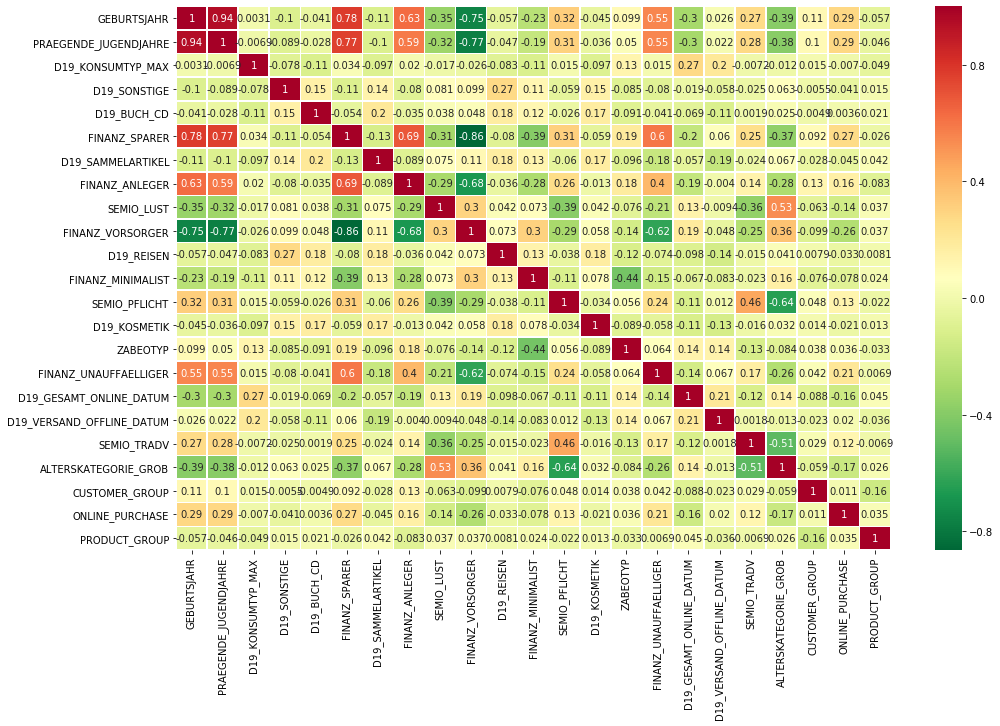

In [32]:
plt.figure(figsize = (16,10))
ax = sns.heatmap(heatmap_c.corr(), cmap='RdYlGn_r', annot=True, linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

## Heatmap for the Azdias correlation

In [33]:
columns = np.concatenate((compare.index[:15], additional_cols), axis=0)
heatmap_a = azdias[columns]
heatmap_a = heatmap_a[heatmap_a['GEBURTSJAHR'] != 0]

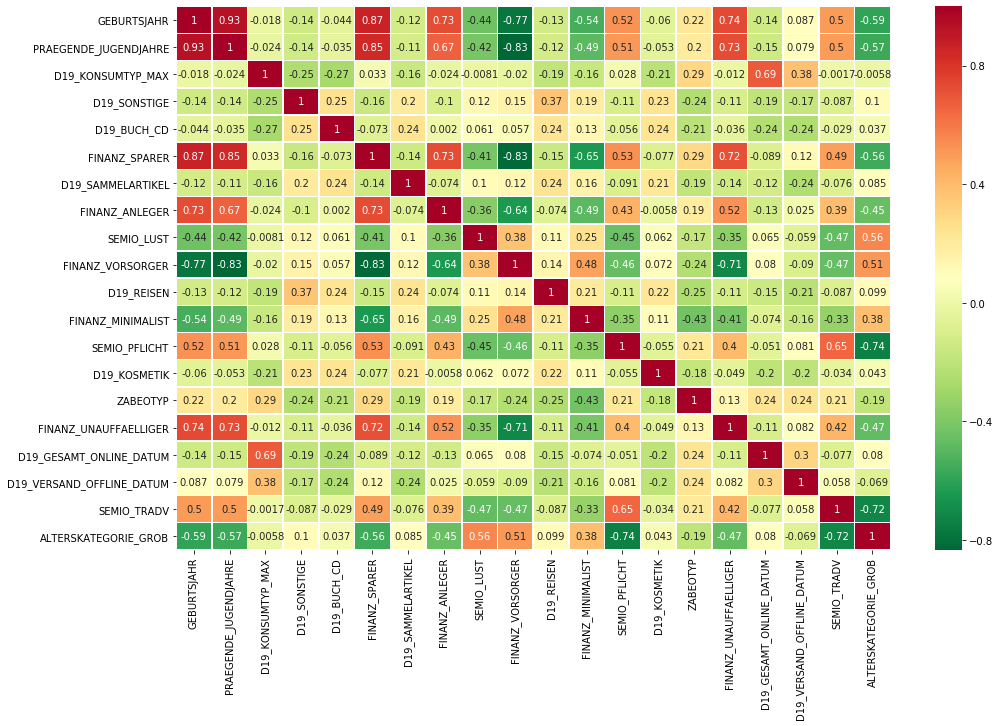

In [34]:
plt.figure(figsize = (16,10))
ax = sns.heatmap(heatmap_a.corr(), cmap='RdYlGn_r', annot=True, linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Plot differences between General Population and Customers

## Ages and teen-years

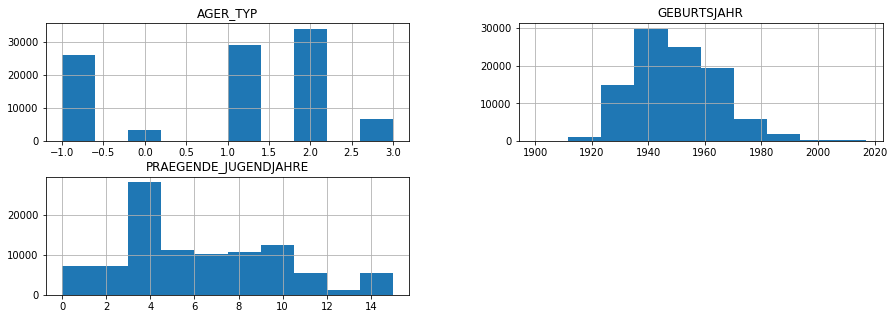

In [35]:
cleaned_customers[['GEBURTSJAHR', 'PRAEGENDE_JUGENDJAHRE', 'AGER_TYP']].hist(figsize = (15,5))
plt.show()

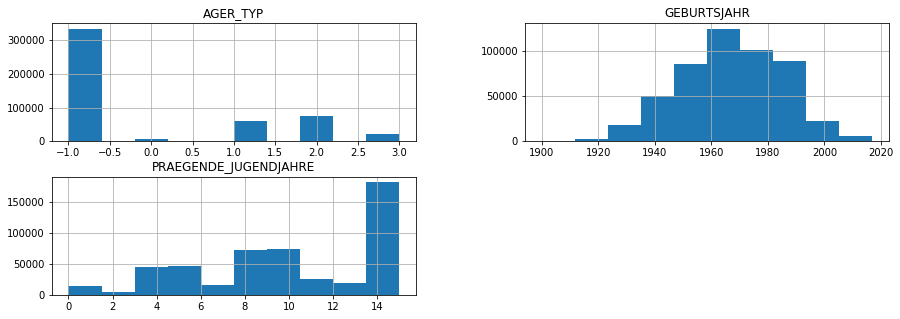

In [36]:
cleaned_azdias[['GEBURTSJAHR', 'PRAEGENDE_JUGENDJAHRE', 'AGER_TYP']].hist(figsize = (15,5))
plt.show()

## Money Savings

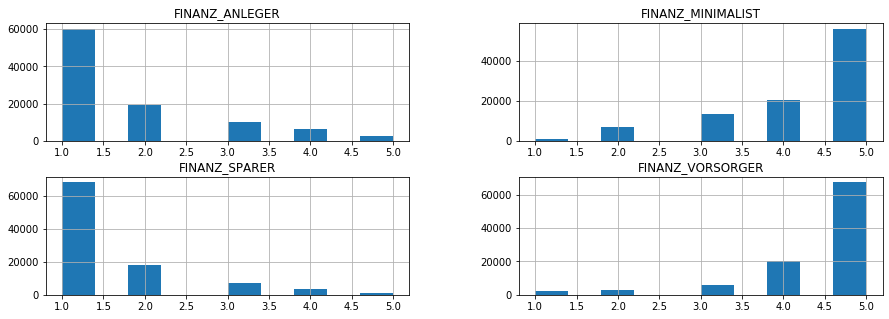

In [37]:
cleaned_customers[['FINANZ_MINIMALIST', 'FINANZ_VORSORGER', 'FINANZ_SPARER', 'FINANZ_ANLEGER']].hist(figsize = (15,5))
plt.show()

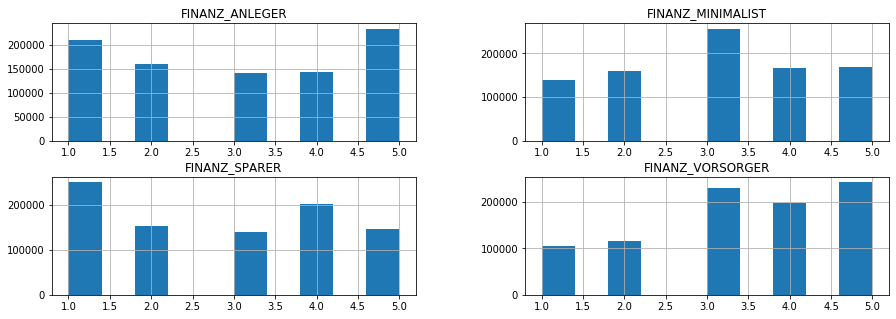

In [38]:
azdias[['FINANZ_MINIMALIST', 'FINANZ_VORSORGER', 'FINANZ_SPARER', 'FINANZ_ANLEGER']].hist(figsize = (15,5))
plt.show()

## Affinity mindsets

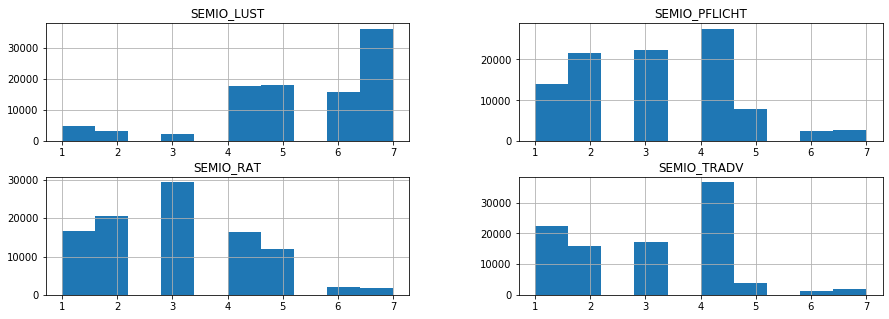

In [39]:
cleaned_customers[['SEMIO_LUST', 'SEMIO_RAT', 'SEMIO_PFLICHT', 'SEMIO_TRADV']].hist(figsize = (15,5))
plt.show()

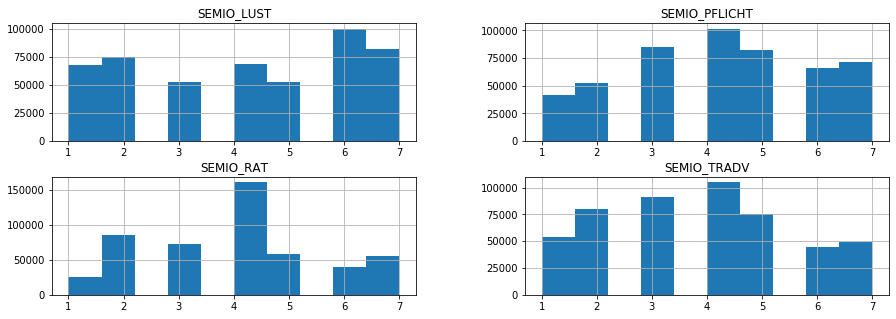

In [40]:
cleaned_azdias[['SEMIO_LUST', 'SEMIO_RAT', 'SEMIO_PFLICHT', 'SEMIO_TRADV']].hist(figsize = (15,5))
plt.show()

## The typical Customer

    The typical customers of Arvato are between 60 and 70 years old. They are financially very stable and saved quite some money. They did precaution for the higher ages in which they are currently in, because they grew up in a time where saving money was essential and pure consumption not normal. So they earned a lot money in the golden 70s to 90s and discovered now the online shopping. Since 91% of all purchases were made online, the customers are still young enough to handle the computer well. Most customers have a affinity to traditional thinking and are more rational and probably more academically educated than the average. For that reason, the most important features are:

##### Information level
- 'AGER_TYP'

##### Person
- 'GEBURTSJAHR' (Birth year)
- 'PRAEGENDE_JUGENDJAHRE' (Important teen years)
- 'ALTERKATEGORIE_GROB' (Age category approximately)
- 'SEMIO_LUST' 
- 'SEMIO_PFLICHT'
- 'SEMIO_RAT'
- 'SEMIO_TRADV'
- 'FINANZ_SPARER' (Finance Saver)
- 'FINANZ_ANLEGER' (Finance Investor)
- 'FINANZ_VORSORGER' (Finance Provision)
- 'FINANZ_MINIMALIST' (Finance Minimalist)

##### Household
- 'D19_KONSUMTYP_MAX' (Consumer type)
- 'D19_VERSAND_OFFLINE_DATUM' (Shipping Offline Date)
- 'D19_GESAMT_OFFLINE_DATUM' (Total Offline Date)

##### 125m x 125m Grid
- 'D19_SAMMELARTIKEL' (Collecting articles)
- 'D19_KOSMETIK' (Cosmetics)
- 'D19_BEKLEIDUNG_REST' (Clothing)
- 'D19_BEKLEIDUNG_GEH' (Clothing)
- 'D19_RATGEBER' (Advisor)
- 'D19_SONSTIGE' (other)
- 'D19_BUCH_CD' (Book, CD)
- 'D19_REISEN' (Journeys)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [41]:
mailout_train = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
print(mailout_train.shape)

(42962, 367)


In [42]:
unique_cols_a = list(set(customers.columns.values) - set(mailout_train.columns.values))
unique_cols_b = list(set(mailout_train.columns.values) - set(azdias.columns.values))

print("Rows in costumer set that are not in mailout: " + str(unique_cols_a))
print("Rows in mailout set that are not in azdias: " + str(unique_cols_b))

Rows in costumer set that are not in mailout: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
Rows in mailout set that are not in azdias: ['RESPONSE']


In [43]:
set(mailout_train.RESPONSE)

{0, 1}

In [44]:
mailout_train.RESPONSE.value_counts() / np.sum(mailout_train.RESPONSE.value_counts())

0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64

In [45]:
trainable_columns = np.concatenate((compare.index[:30], additional_cols, np.array(unique_cols)), axis=0)

train_data = customers[trainable_columns]

train_data = train_data[train_data['PRAEGENDE_JUGENDJAHRE'] != 0]

In [46]:
map_missing_years = {1: 1945, 2: 1945, 3: 1955, 4:1955, 5:1965, 6:1965, 7:1965, 8:1975, 9:1975,
                    10: 1985, 11:1985, 12:1985, 13:1985, 14:1995, 15:1995}

In [47]:
to_mapping_years = train_data[train_data['GEBURTSJAHR'] == 0]['PRAEGENDE_JUGENDJAHRE'].map(map_missing_years).values

train_data.loc[train_data['GEBURTSJAHR'] == 0, 'GEBURTSJAHR'] = to_mapping_years

train_data['PRODUCT_GROUP'] = train_data['PRODUCT_GROUP'].factorize()[0]
train_data['CUSTOMER_GROUP'] = train_data['CUSTOMER_GROUP'].factorize()[0]

In [48]:
train_data = train_data.dropna()

In [49]:
X = train_data[np.concatenate((compare.index[:10], additional_cols))]
y = train_data['CUSTOMER_GROUP']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [50]:
print("X_train: " + str(X_train.shape))
print("y_train: " + str(y_train.shape))
print("X_test: " + str(X_test.shape))
print("y_test: " + str(y_test.shape))

X_train: (128848, 18)
y_train: (128848,)
X_test: (14317, 18)
y_test: (14317,)


In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
lr = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.670252147796326


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [264]:
mailout_test = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [269]:
mailout_test.shape

(42833, 366)